# Temperature distribution in Warsaw

This document presents an analysis of average temperature variations across different locations in Warsaw, comparing distinct time periods.
The project reveals significant insights into the changing climate patterns within the city and utilizes heatmaps to visualise data.

## Setup

In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests
!pip install matplotlib numpy
!pip install pandas geopandas
!pip install contextily shapely

### Define helper functions

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import openmeteo_requests
import requests_cache
from retry_requests import retry
import contextily as ctx

def initialize_client():
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    return openmeteo_requests.Client(session=retry_session)

def get_location_pairs(latitude_range, longitude_range, accuracy):
    latitude = np.linspace(latitude_range[0], latitude_range[1], accuracy).astype(np.float64)
    longitude = np.linspace(longitude_range[0], longitude_range[1], accuracy).astype(np.float64)
    return list(itertools.product(latitude, longitude))

def fetch_weather_data(client, location_pairs, start_date, end_date, model="CMCC_CM2_VHR4"):
    url = "https://climate-api.open-meteo.com/v1/climate"
    params = {
        "latitude": [pair[0] for pair in location_pairs],
        "longitude": [pair[1] for pair in location_pairs],
        "start_date": start_date,
        "end_date": end_date,
        "models": [model],
        "daily": "temperature_2m_mean"
    }
    return client.weather_api(url, params=params)

def get_temperature_data(client, location_pairs, start_date, end_date):
    responses = fetch_weather_data(client, location_pairs, start_date, end_date)
    return [float(response.Daily().Variables(0).ValuesAsNumpy().mean()) for response in responses]

def prepare_geodataframe(location_pairs, temperatures):
    data = {
        'Latitude': [pair[0] for pair in location_pairs],
        'Longitude': [pair[1] for pair in location_pairs],
        'Temperature': temperatures
    }
    gdf = gpd.GeoDataFrame(data, geometry=[Point(lon, lat) for lon, lat in zip(data['Longitude'], data['Latitude'])])
    gdf.crs = "EPSG:4326"
    return gdf

def plot_heatmap(gdf, title):
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf.plot(ax=ax, column='Temperature', cmap='coolwarm', markersize=150, alpha=0.75, legend=True)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

### Define heatmap accuracy and coordinates of Warsaw

In [3]:
latitude_range = (52.08, 52.36)
longitude_range = (20.85, 21.14)
accuracy = 12 # heatmap accuracy
    

client = initialize_client()
location_pairs = get_location_pairs(latitude_range, longitude_range, accuracy)

## Mean temperature 2020-2023

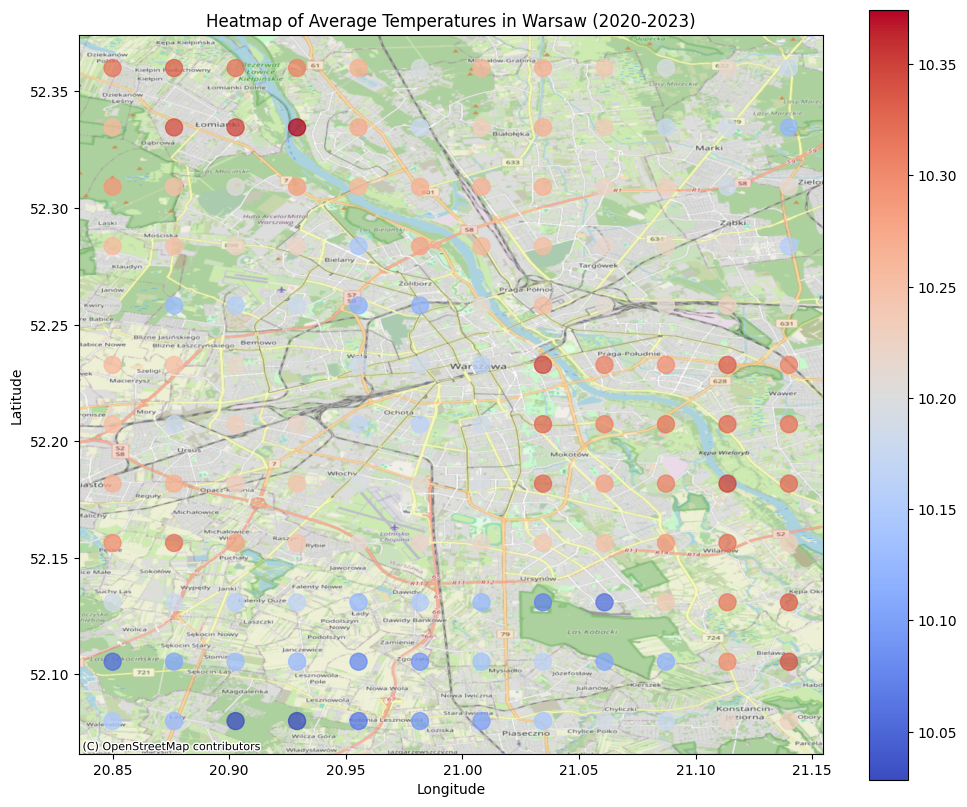

In [4]:
start_date = "2020-01-01"
end_date = "2023-12-31"
temperatures = get_temperature_data(client, location_pairs, start_date, end_date)
gdf = prepare_geodataframe(location_pairs, temperatures)
plot_heatmap(gdf, 'Heatmap of Average Temperatures in Warsaw (2020-2023)')

##  Mean temperature 1990-1993

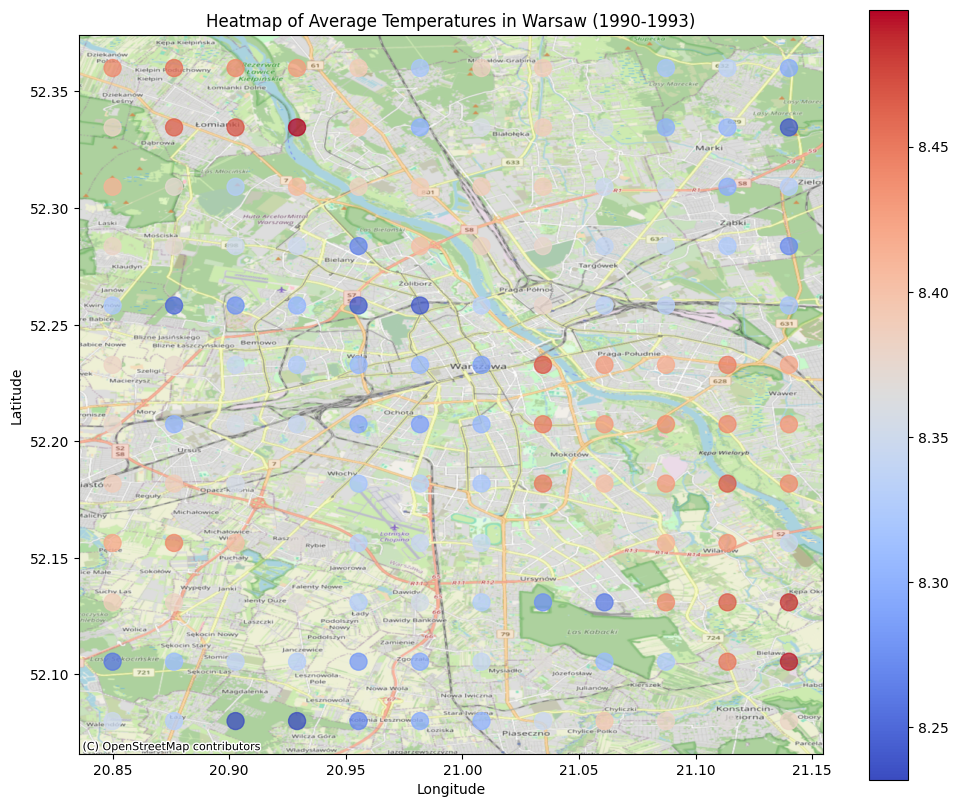

In [5]:
start_date = "1990-01-01"
end_date = "1993-12-31"
temperatures = get_temperature_data(client, location_pairs, start_date, end_date)
gdf = prepare_geodataframe(location_pairs, temperatures)
plot_heatmap(gdf, 'Heatmap of Average Temperatures in Warsaw (1990-1993)')

## Mean summer temperature 2023

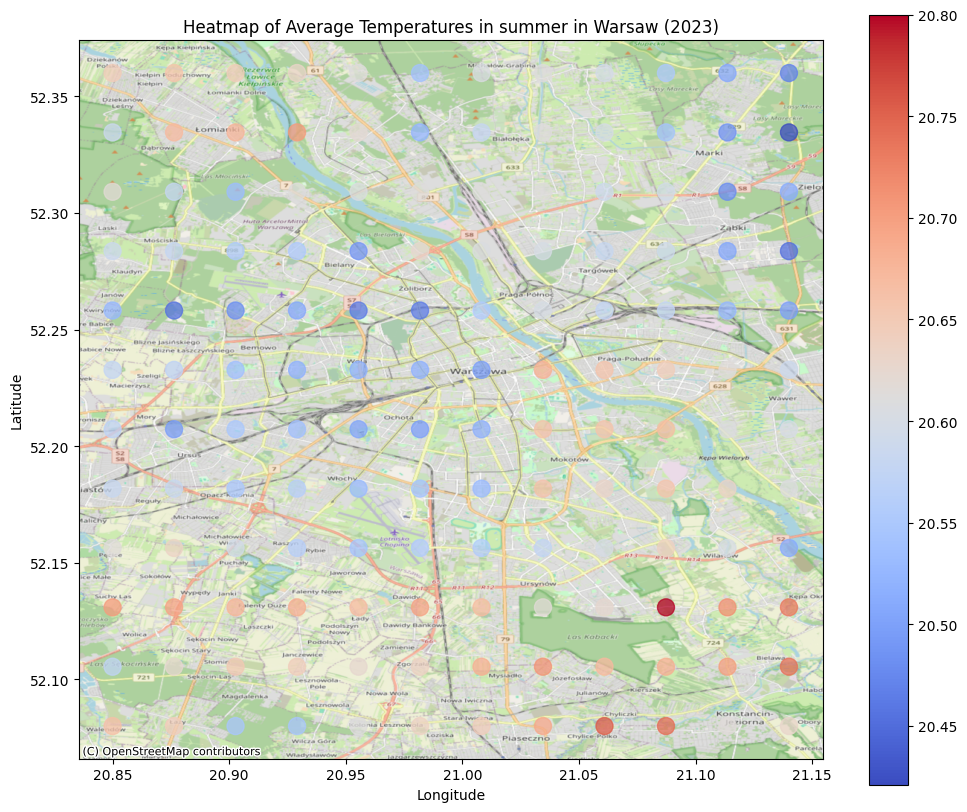

In [6]:
start_date = "2023-06-21"
end_date = "2023-09-23"
temperatures = get_temperature_data(client, location_pairs, start_date, end_date)
gdf = prepare_geodataframe(location_pairs, temperatures)
plot_heatmap(gdf, 'Heatmap of Average Temperatures in summer in Warsaw (2023)')

## Summary
As one can easily notice on above plots, temperature in Warsaw varies depending on the exact location. 
The most interesting conclusion are:

#### Temperature variation: 
In all configurations and time periods, the mean temperature varied by up to 0.5°C depending on the specific location within the city.

#### Overall temperature increase
The maximum mean temperature recorded in the period 1990-1993 was around 8.50°C. In contrast, during 2020-2023, the maximum temperature exceeded 10.35°C, indicating a significant rise in average temperatures over the past few decades. This may be caused both by the global warming and urbanization as well as overall Warsaw expansion and development.

#### Unexpected hotspots
Interestingly, the city center of Warsaw is not the hottest area on the map in either time period. Furthermore, data suggests lack of the urban heat island effect, where urban areas usually experience higher temperatures than their rural surroundings. Even more unexpectedly, this effect is absent during the summer months as well.
